In [1]:
import os
import warnings

from jupyterthemes import jtplot
import matplotlib.cbook
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import pandas as pd
import seaborn as sns

In [2]:
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)
jtplot.style(figsize=(15, 6), grid=False)

In [3]:
def show_response_rate(data, field, top_n=None, count_type='bar', title=None):
    ds = data[data[field].notnull()].groupby(field).converted.agg(['count', 'sum'])
    ds['response_rate'] = ds['sum'] / ds['count']
    if top_n:
        ds = ds.sort_values(by='count', ascending=False).head(top_n).reset_index()
    else:
        ds = ds.reset_index()

    fig, ax = plt.subplots()
    ax2 = ax.twinx()

    if count_type == 'distplot':
        sns.distplot(data[data[field].notnull()][field], ax=ax, label='Distribution of customers')
    else:
        ax.bar(ds.index, ds["count"], color="b", label='Distribution of customers')
        ax.set_xticks(ds.index)
        ax.set_xticklabels(ds[field])

    ax2.plot(ds.index, ds["response_rate"], color='green', label='Response rate', lw=2, marker='o', markersize=10)
    ax.set_ylabel("Number of customers")
    ax.set_xlabel(field)
    ax2.set_ylabel("Response rate")
    ax2.set_ylim(0, ax2.get_ylim()[1])
    ax2.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.2%}'.format(y)))
    plts, labels = ax.get_legend_handles_labels()
    plts2, labels2 = ax2.get_legend_handles_labels()
    ax.legend(plts + plts2, labels + labels2, loc='upper left', bbox_to_anchor=(1.1, 1))
    ax.set_xticklabels(ax.get_xticklabels(),
                       rotation=0 if max(len(x.get_text()) for x in ax.get_xticklabels()) < 9 else 20, ha='right')
    fig.suptitle("Response rate by {}.".format(field if not isinstance(title, str) else title))
    return ds

In [4]:
def show_disaggregated_by(data, variable, hue, top_n=None, stacked=True, variable_impact=True, show_convertion_labels=True):
    if data[variable].dtype.name == 'category':
        x_values = data[variable].astype('object')
    else:
        x_values = data[variable]
    if data[hue].dtype.name == 'category':
        hue_values = data[hue].astype('object')
    else:
        hue_values = data[hue]

    ds = data.groupby([x_values, hue_values]).converted.agg(['mean', 'count']).unstack().fillna(0)
    totals = ds['count'].sum(axis='columns')

    response_rate_ds = ds['mean'].copy()
    q = ds['count'].div(totals, axis='index')
    if top_n is not None:
        ordered_index = totals.sort_values(ascending=False).index
        q = q.loc[ordered_index].iloc[:top_n, :]
        response_rate_ds = response_rate_ds.loc[ordered_index].iloc[:top_n, :]

    if variable_impact:
        fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(15, 12), gridspec_kw={'height_ratios': [2, 1, 1]})
    else:
        fig, ax1 = plt.subplots(1, figsize=(15, 6))

    ax = q.plot.bar(stacked=stacked, ax=ax1)
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
    ax.xaxis.set_tick_params(rotation=0)
    ax.set_xticklabels(ax.get_xticklabels(),
                       rotation=0 if max(len(x.get_text()) for x in ax.get_xticklabels()) < 9 else 20, ha='right')
    ax.set_title("Ratio of {} by {} with response rate.".format(hue, variable))
    if show_convertion_labels:
        for cr, p in zip(response_rate_ds.values.T.flat, ax.patches):
            xs = p.get_x()
            ys = p.get_y()
            h = p.get_height()
            w = p.get_width()
            y = ys + h / 2
            x = xs + w / 2
            if h > 0.03:
                label = "{:.1%}".format(cr)
                bbox_props = dict(boxstyle="round,pad=0.3", fc="cyan", ec="b", lw=2)
                ax.text(x, y, label, ha="center", va="center", size=10, bbox=bbox_props, color='black')

    if variable_impact:
        plt.subplots_adjust(hspace=0.15)
        ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
        ax.set_xlabel('')
        ax.tick_params(bottom='off', labelbottom='off')

        impact = ds['mean'].unstack().reset_index()
        impact = impact.rename(columns={0: 'conversion', hue: 'product'})
        variable_mean = impact.groupby(variable).conversion.agg('sum').reset_index()
        impact = impact.merge(variable_mean, on=variable, suffixes=('', '_sum_variable'))
        impact['conversion_norm_by_var'] = impact['conversion'] / impact['conversion_sum_variable']

        offer_distribution = q.unstack().reset_index()
        offer_distribution = offer_distribution.rename(columns={0: 'conversion', hue: 'product'})
        variable_mean2 = offer_distribution.groupby(variable).conversion.agg('sum').reset_index()
        offer_distribution = offer_distribution.merge(variable_mean2, on=variable, suffixes=('', '_sum_variable'))
        offer_distribution['conversion_norm_by_var'] = offer_distribution['conversion'] / offer_distribution[
            'conversion_sum_variable']

        ax2 = sns.pointplot(x=variable, y='conversion_norm_by_var', hue='product', data=impact, ax=ax2)
        ax2.legend_.remove()
        ax2.set_yticklabels([])
        ax2.set_xlabel('')
        ax2.set_ylabel('')
        ax2.tick_params(bottom='off', labelbottom='off')
        ax2.set_title("Impact of {} on response rate.".format(variable))

        ax3 = sns.pointplot(x=variable, y='conversion_norm_by_var', hue='product', data=offer_distribution, ax=ax3)
        ax3.legend_.remove()
        ax3.set_yticklabels([])
        ax3.set_ylabel('')
        ax3.set_title("Distribution of offers by {}.".format(variable))
        ax3.set_xticklabels(ax3.get_xticklabels(),
                            rotation=0 if max(len(x.get_text()) for x in ax3.get_xticklabels()) < 9 else 20, ha='right')

## Load example data

In [5]:
data = pd.read_csv(os.path.join('..', 'data', 'phone_offers.csv.gz'), compression='gzip')
data.head()

,phone_brand,tenure,converted
0,Apple,1,False
1,Samsung,1,False
2,Apple,1,False
3,Google,4,False
4,Google,2,False


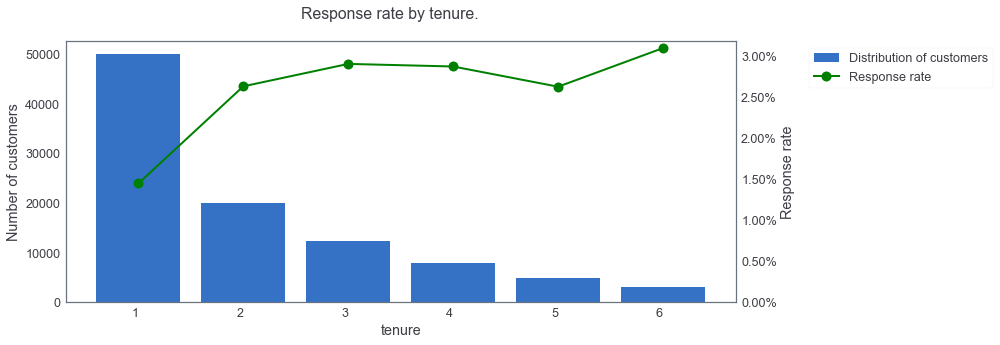

In [6]:
variable = 'tenure'
_ = show_response_rate(data, variable)

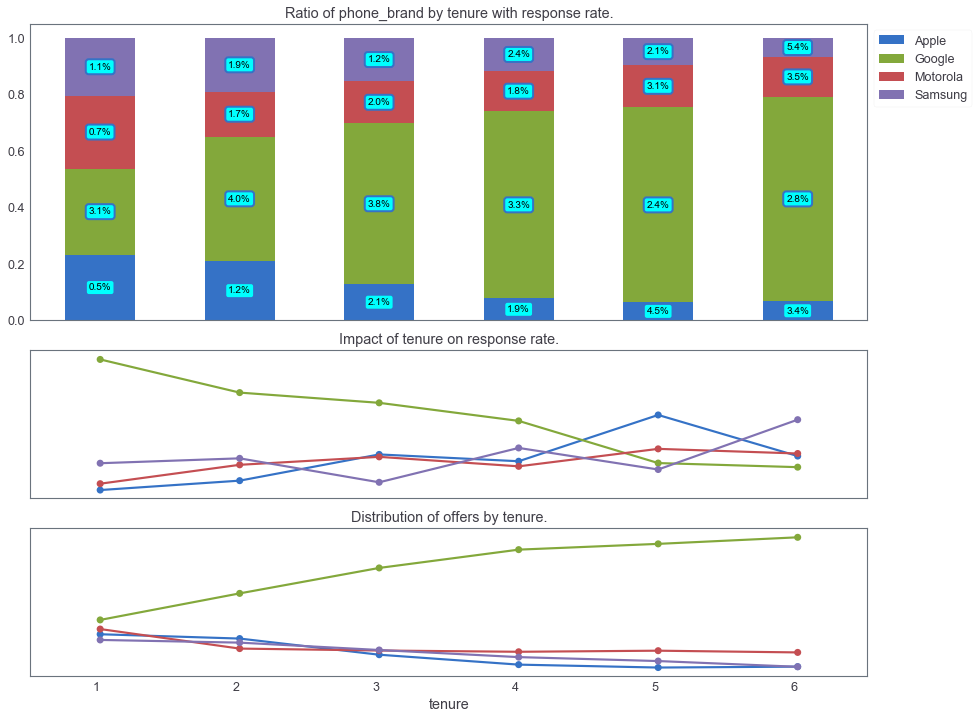

In [7]:
show_disaggregated_by(data, variable, 'phone_brand')